### Denoising Autoencoders And Where To Find Them (10 pts)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [4]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py

--2022-12-15 17:39:12--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-12-15 17:39:12 (36.1 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]



In [3]:
# !pip install Image Pillow==5.1.0 scipy==1.1.0
!pip install Image Pillow scipy

  Using cached image-1.5.33-py2.py3-none-any.whl
  Using cached Django-4.1.4-py3-none-any.whl (8.1 MB)
  Using cached asgiref-3.5.2-py3-none-any.whl (22 kB)


In [6]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda:3") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

cuda:3


In [7]:
BATCH_SIZE = 32

In [8]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

images not found, donwloading...


--2022-12-15 17:40:18--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  189K 15m31s
    50K .......... .......... .......... .......... ..........  0%  380K 11m37s
   100K .......... .......... .......... .......... ..........  0% 36.5M 7m46s
   150K .......... .......... .......... .......... ..........  0% 49.0M 5m51s
   200K .......... .......... .......... .......... ..........  0%  383K 6m12s
   250K .......... .......... .......... .......... ..........  0% 52.9M 5m11s
   300K .......... .......... .......... .......... ..........  0% 44.6M 4m27s
   350K .......... .......... .......... .......... ..........  0% 41.7M 3m54s
   400K .......... ....

extracting...
lfw/
lfw/George_HW_Bush/
lfw/George_HW_Bush/George_HW_Bush_0001.jpg
lfw/George_HW_Bush/George_HW_Bush_0002.jpg
lfw/George_HW_Bush/George_HW_Bush_0003.jpg
lfw/George_HW_Bush/George_HW_Bush_0004.jpg
lfw/George_HW_Bush/George_HW_Bush_0005.jpg
lfw/George_HW_Bush/George_HW_Bush_0006.jpg
lfw/George_HW_Bush/George_HW_Bush_0007.jpg
lfw/George_HW_Bush/George_HW_Bush_0008.jpg
lfw/George_HW_Bush/George_HW_Bush_0009.jpg
lfw/George_HW_Bush/George_HW_Bush_0010.jpg
lfw/George_HW_Bush/George_HW_Bush_0011.jpg
lfw/George_HW_Bush/George_HW_Bush_0012.jpg
lfw/George_HW_Bush/George_HW_Bush_0013.jpg
lfw/Curtis_Strange/
lfw/Curtis_Strange/Curtis_Strange_0001.jpg
lfw/Marc_Grossman/
lfw/Marc_Grossman/Marc_Grossman_0001.jpg
lfw/Marc_Grossman/Marc_Grossman_0002.jpg
lfw/Marc_Grossman/Marc_Grossman_0003.jpg
lfw/Marc_Grossman/Marc_Grossman_0004.jpg
lfw/Michael_Schumacher/
lfw/Michael_Schumacher/Michael_Schumacher_0001.jpg
lfw/Michael_Schumacher/Michael_Schumacher_0002.jpg
lfw/Michael_Schumacher/Michael

--2022-12-15 17:40:31--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2022-12-15 17:40:32--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  182K 79s
    50K .......... .......... .......... .......... ..........  0%  476K 55s
   100K .......... .......... .......... .......... ..........  1% 86.5M 36s
   150K .......... .......... ..........

done


In [10]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [11]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


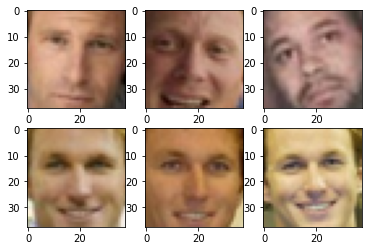

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [13]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [15]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        x = self.enc(batch)
        x = self.dec(x)
        reconstruction = x
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [16]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [18]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [19]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 315.51it/s]


1, Train loss: 0.10512276307834817, Test loss: 0.023198197526383458


370it [00:00, 453.06it/s]


2, Train loss: 0.022406209769157418, Test loss: 0.022414438632050258


370it [00:00, 482.99it/s]


3, Train loss: 0.022042031992240897, Test loss: 0.022048517947149873


370it [00:00, 475.74it/s]


4, Train loss: 0.02179379123062761, Test loss: 0.02186953999222817


370it [00:00, 450.62it/s]


5, Train loss: 0.021442445987206297, Test loss: 0.021184578010470127


370it [00:00, 465.81it/s]


6, Train loss: 0.02074860200281247, Test loss: 0.02031864492654493


370it [00:00, 488.32it/s]


7, Train loss: 0.01937859655778162, Test loss: 0.018560821827038904


370it [00:00, 478.82it/s]


8, Train loss: 0.017538970905115647, Test loss: 0.01675218544520815


370it [00:00, 456.92it/s]


9, Train loss: 0.015944069884044426, Test loss: 0.01645951495665686


370it [00:00, 469.44it/s]


10, Train loss: 0.014965239045673722, Test loss: 0.014362980099447975


370it [00:00, 477.68it/s]


11, Train loss: 0.013847213499722105, Test loss: 0.013455743234786686


370it [00:00, 470.18it/s]


12, Train loss: 0.012850936654204531, Test loss: 0.013056479365272086


370it [00:00, 486.91it/s]


13, Train loss: 0.011752251808518476, Test loss: 0.011802881854951276


370it [00:00, 487.54it/s]


14, Train loss: 0.010929979100372458, Test loss: 0.010614063560099952


370it [00:00, 490.06it/s]


15, Train loss: 0.009983577430869165, Test loss: 0.009998881044669571


370it [00:00, 484.95it/s]


16, Train loss: 0.009409156357360683, Test loss: 0.009068444102645548


370it [00:00, 467.69it/s]


17, Train loss: 0.008860923561981813, Test loss: 0.008463222501213251


370it [00:00, 475.27it/s]


18, Train loss: 0.00840636322358572, Test loss: 0.008361873622496572


370it [00:00, 490.17it/s]


19, Train loss: 0.007966470971656014, Test loss: 0.007594846554572381


370it [00:00, 490.63it/s]


20, Train loss: 0.007623352432417629, Test loss: 0.007437087873391212


370it [00:00, 488.83it/s]


21, Train loss: 0.007376002170133944, Test loss: 0.0069910411187791895


370it [00:00, 465.96it/s]


22, Train loss: 0.007058438102215427, Test loss: 0.006947165862538017


370it [00:00, 474.20it/s]


23, Train loss: 0.006884611435750281, Test loss: 0.006822437786768746


370it [00:00, 486.68it/s]


24, Train loss: 0.0065609032397699624, Test loss: 0.006495858481406503


370it [00:00, 492.12it/s]


25, Train loss: 0.006444179906039871, Test loss: 0.008294841837755853


370it [00:00, 492.56it/s]


26, Train loss: 0.006342956128405134, Test loss: 0.0062580203890041835


370it [00:00, 491.33it/s]


27, Train loss: 0.006183147462886753, Test loss: 0.006132844121078311


370it [00:00, 491.02it/s]


28, Train loss: 0.006109663293816024, Test loss: 0.006024247979648715


370it [00:00, 477.61it/s]


29, Train loss: 0.006005911757757586, Test loss: 0.005920343190750214


370it [00:00, 488.86it/s]


30, Train loss: 0.005890232154583414, Test loss: 0.0058935815729522735


370it [00:00, 470.82it/s]


31, Train loss: 0.0057753392687398125, Test loss: 0.005713512377404227


370it [00:00, 481.25it/s]


32, Train loss: 0.005700280222549172, Test loss: 0.005948431973395705


370it [00:00, 488.43it/s]


33, Train loss: 0.005639908202424327, Test loss: 0.005804330030104494


370it [00:00, 451.08it/s]


34, Train loss: 0.00555498478493357, Test loss: 0.005582332893050535


370it [00:00, 466.58it/s]


35, Train loss: 0.005472650084501362, Test loss: 0.005483118599178623


370it [00:00, 457.69it/s]


36, Train loss: 0.005541664064339216, Test loss: 0.005462234497275728


370it [00:00, 476.97it/s]


37, Train loss: 0.0054577033576379465, Test loss: 0.006092946952208267


370it [00:00, 464.43it/s]


38, Train loss: 0.005420908409689211, Test loss: 0.005352529893577669


370it [00:00, 478.92it/s]


39, Train loss: 0.005381073714205905, Test loss: 0.005373498379465887


370it [00:00, 469.84it/s]


40, Train loss: 0.005332778436962182, Test loss: 0.00557362992421027


In [20]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.005595926361150356


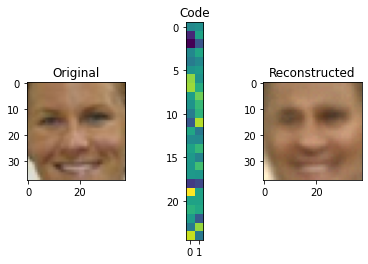

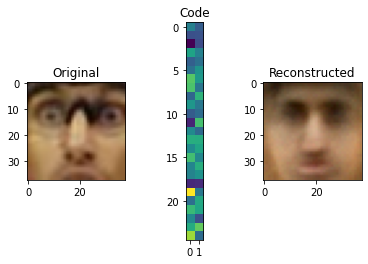

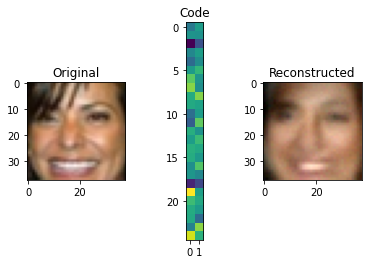

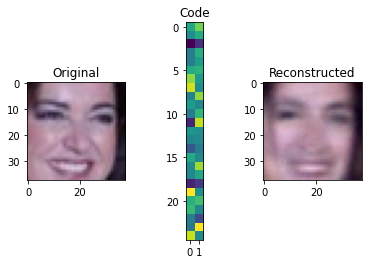

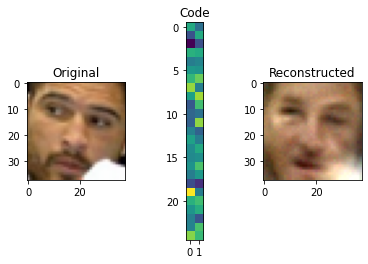

In [21]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [242]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        input_dim = np.prod(img_shape)

        self.enc = nn.Sequential(
            Reshape(-1, input_dim),
            nn.Linear(input_dim, 16*code_size),
            nn.GELU(),
            nn.Linear(16*code_size, 4*code_size),
            nn.GELU(),
            nn.Linear(4*code_size, 2*code_size),
            nn.GELU(),
            nn.Linear(2*code_size, code_size),
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, 2*code_size),
            nn.GELU(),
            nn.Linear(2*code_size, 4*code_size),
            nn.GELU(),
            nn.Linear(4*code_size, 16*code_size),
            nn.GELU(),
            nn.Linear(16*code_size, input_dim),
            Reshape(-1, img_shape[0], img_shape[1], img_shape[2]),
        )
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [244]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor.to(torch.float32), batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [245]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

370it [00:01, 198.10it/s]


1, Train loss: 0.023787325819359783, Test loss: 0.01847443205174436


370it [00:01, 190.06it/s]


2, Train loss: 0.01575041226879485, Test loss: 0.014832008796103649


370it [00:01, 188.34it/s]


3, Train loss: 0.013498935041959172, Test loss: 0.012826716352116943


370it [00:01, 190.17it/s]


4, Train loss: 0.012312143224800263, Test loss: 0.011951799947876368


370it [00:01, 190.27it/s]


5, Train loss: 0.011437015326201535, Test loss: 0.011028061067794982


370it [00:01, 189.21it/s]


6, Train loss: 0.01048307114250491, Test loss: 0.010413224803429908


370it [00:01, 189.73it/s]


7, Train loss: 0.00989339438354012, Test loss: 0.010623047943348736


370it [00:01, 189.23it/s]


8, Train loss: 0.009574752598686793, Test loss: 0.009384788517477146


370it [00:01, 190.40it/s]


9, Train loss: 0.009131254182031635, Test loss: 0.009093224323939412


370it [00:01, 189.05it/s]


10, Train loss: 0.008766277074583856, Test loss: 0.008804977161328527


370it [00:01, 186.37it/s]


11, Train loss: 0.00839211208065527, Test loss: 0.00890867171709063


370it [00:01, 194.14it/s]


12, Train loss: 0.008141863770690037, Test loss: 0.00806481323809435


370it [00:01, 190.01it/s]


13, Train loss: 0.007922124889672501, Test loss: 0.007851418876114026


370it [00:01, 186.75it/s]


14, Train loss: 0.007571827025537195, Test loss: 0.0075928094812153105


370it [00:02, 180.22it/s]


15, Train loss: 0.007413869645645775, Test loss: 0.007498391488099586


370it [00:01, 187.95it/s]


16, Train loss: 0.0071537196197310905, Test loss: 0.007419923662271341


370it [00:01, 189.49it/s]


17, Train loss: 0.006978010914296293, Test loss: 0.007172632844729995


370it [00:01, 188.70it/s]


18, Train loss: 0.006854204439191776, Test loss: 0.0070452214983735394


370it [00:01, 190.75it/s]


19, Train loss: 0.006721695171306725, Test loss: 0.0068175077123889555


370it [00:01, 189.77it/s]


20, Train loss: 0.006589769191992766, Test loss: 0.006732169591929534


370it [00:01, 186.57it/s]


21, Train loss: 0.006503923073925248, Test loss: 0.006752354184269762


370it [00:02, 173.24it/s]


22, Train loss: 0.006419789204795146, Test loss: 0.006591558516292037


370it [00:01, 212.94it/s]


23, Train loss: 0.006367259147115472, Test loss: 0.006457562689554962


370it [00:01, 214.91it/s]


24, Train loss: 0.0062542311935125565, Test loss: 0.006499407935278826


370it [00:01, 214.86it/s]


25, Train loss: 0.006204355827858479, Test loss: 0.006608494916631627


370it [00:01, 214.99it/s]


26, Train loss: 0.006134680424735838, Test loss: 0.006309630249664978


370it [00:01, 197.61it/s]


27, Train loss: 0.006031097272358344, Test loss: 0.006423101070556529


370it [00:01, 191.46it/s]


28, Train loss: 0.005933905727726456, Test loss: 0.006140120223273979


370it [00:01, 191.65it/s]


29, Train loss: 0.005899574609781731, Test loss: 0.006557470224183207


370it [00:01, 189.79it/s]


30, Train loss: 0.005776341348519344, Test loss: 0.0059735400051407804


370it [00:01, 189.23it/s]


31, Train loss: 0.005713405968562498, Test loss: 0.0059773452525087286


370it [00:01, 186.71it/s]


32, Train loss: 0.005717176543978855, Test loss: 0.005879543672748779


370it [00:01, 187.40it/s]


33, Train loss: 0.00567302473722454, Test loss: 0.005923247033670605


370it [00:01, 189.63it/s]


34, Train loss: 0.0056076049083140615, Test loss: 0.0059569326637286335


370it [00:01, 185.95it/s]


35, Train loss: 0.005562677048106137, Test loss: 0.006099780699326159


370it [00:01, 197.88it/s]


36, Train loss: 0.0054793722793150665, Test loss: 0.006232653821597193


370it [00:01, 188.56it/s]


37, Train loss: 0.005447216904409447, Test loss: 0.005688598460980203


370it [00:01, 187.56it/s]


38, Train loss: 0.005399145632443047, Test loss: 0.005687311676553466


370it [00:01, 185.50it/s]


39, Train loss: 0.005366194009479011, Test loss: 0.005870096519375864


370it [00:02, 184.28it/s]


40, Train loss: 0.005326673120532288, Test loss: 0.005591428184152523


370it [00:01, 187.24it/s]


41, Train loss: 0.005293037172462075, Test loss: 0.005652333067159708


370it [00:01, 187.44it/s]


42, Train loss: 0.00524456955491652, Test loss: 0.005594104948475213


370it [00:01, 188.02it/s]


43, Train loss: 0.0052388209489129655, Test loss: 0.0055984255613766645


370it [00:01, 189.30it/s]


44, Train loss: 0.005190341680179668, Test loss: 0.005515933346231123


370it [00:01, 187.30it/s]


45, Train loss: 0.005152946023834539, Test loss: 0.005629201152633277


370it [00:01, 188.99it/s]


46, Train loss: 0.0051550343878456134, Test loss: 0.005406118759224706


370it [00:01, 189.31it/s]


47, Train loss: 0.0051126911780786455, Test loss: 0.005478063472897689


370it [00:01, 189.52it/s]


48, Train loss: 0.005102393077330738, Test loss: 0.005338285355128156


370it [00:01, 189.50it/s]


49, Train loss: 0.005085433556504705, Test loss: 0.0054022690697987695


370it [00:01, 188.89it/s]


50, Train loss: 0.005042363084457462, Test loss: 0.005501701409592554


Training may take long, it's okay.

Final MSE: 0.005414857389997431


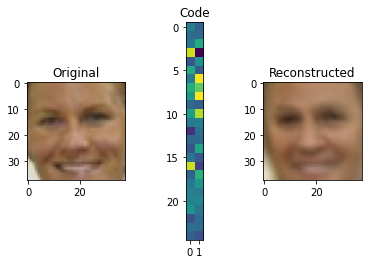

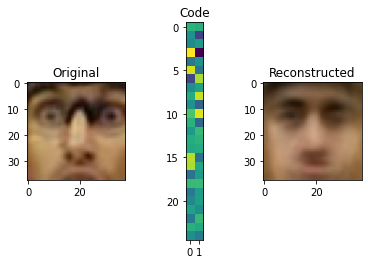

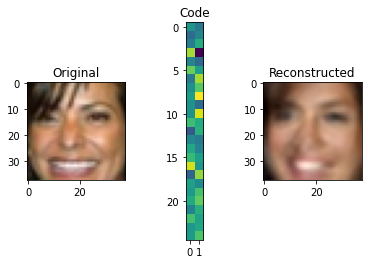

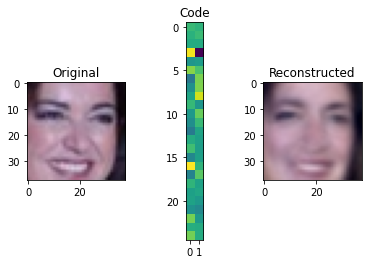

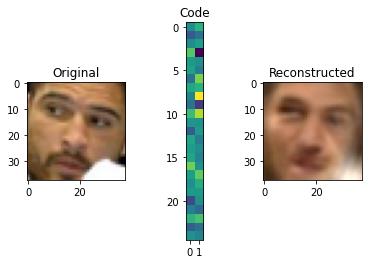

In [246]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [247]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = torch.empty_like(X).normal_(0, sigma)
        
    return X + noise
    

In [248]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

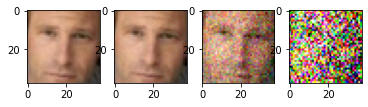

In [249]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [251]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:08, 42.00it/s]


1, Train loss: 0.023748872423297956, Test loss: 0.01932603140027888


370it [00:08, 42.52it/s]


2, Train loss: 0.015735980264284303, Test loss: 0.015126623471848222


370it [00:08, 42.90it/s]


3, Train loss: 0.01354766080909924, Test loss: 0.01272626997110796


370it [00:08, 41.97it/s]


4, Train loss: 0.012059115487984245, Test loss: 0.012069514718592043


370it [00:08, 42.75it/s]


5, Train loss: 0.011418848279434096, Test loss: 0.010895760835808834


370it [00:08, 41.48it/s]


6, Train loss: 0.010237905242533847, Test loss: 0.009987596694163213


370it [00:09, 40.56it/s]


7, Train loss: 0.00977526191585493, Test loss: 0.009870768179561664


370it [00:09, 40.82it/s]


8, Train loss: 0.009479522780706528, Test loss: 0.009233663395429926


370it [00:08, 43.21it/s]


9, Train loss: 0.009035768267410049, Test loss: 0.008928762198856724


370it [00:08, 43.23it/s]


10, Train loss: 0.008711239276625397, Test loss: 0.008723946431265138


370it [00:08, 43.45it/s]


11, Train loss: 0.008504580625908543, Test loss: 0.008569221279549467


370it [00:08, 43.87it/s]


14, Train loss: 0.007676710617497872, Test loss: 0.007727738426462336


370it [00:08, 43.45it/s]


15, Train loss: 0.0074269606012492195, Test loss: 0.007770012126145736


370it [00:08, 44.22it/s]


16, Train loss: 0.00728082274677761, Test loss: 0.007389913071115283


370it [00:08, 43.35it/s]


17, Train loss: 0.007105635024201919, Test loss: 0.007231803691733492


370it [00:08, 44.35it/s]


18, Train loss: 0.006969268850804271, Test loss: 0.0072397627192979635


370it [00:08, 43.22it/s]


19, Train loss: 0.0068256332314044, Test loss: 0.00707725061313731


370it [00:08, 42.01it/s]


20, Train loss: 0.006712143215900661, Test loss: 0.006779338389394084


370it [00:08, 41.94it/s]


21, Train loss: 0.006592942431772825, Test loss: 0.006802972630840333


370it [00:08, 42.41it/s]


22, Train loss: 0.00652477212169049, Test loss: 0.006833808558338506


370it [00:08, 41.89it/s]


23, Train loss: 0.0064646580772410416, Test loss: 0.006476488563221906


370it [00:08, 42.37it/s]


24, Train loss: 0.0063726256301289835, Test loss: 0.006490225635543293


370it [00:08, 41.93it/s]


25, Train loss: 0.006255767565578693, Test loss: 0.0062670396367578134


370it [00:08, 42.37it/s]


26, Train loss: 0.006170525027310071, Test loss: 0.006476551864980727


370it [00:08, 43.42it/s]


27, Train loss: 0.006115135266030935, Test loss: 0.00621166764788448


370it [00:08, 43.83it/s]


28, Train loss: 0.005988198536458695, Test loss: 0.006168348142863292


370it [00:08, 43.19it/s]


29, Train loss: 0.0059920001276881135, Test loss: 0.0060634784418648075


370it [00:08, 44.04it/s]


30, Train loss: 0.005893580871643904, Test loss: 0.006122980147028954


370it [00:08, 43.33it/s]


31, Train loss: 0.005854824026055328, Test loss: 0.006238346426571649


370it [00:08, 43.30it/s]


32, Train loss: 0.005822746456275614, Test loss: 0.00609021142141201


370it [00:08, 43.38it/s]


33, Train loss: 0.005753777049729863, Test loss: 0.005871780608486123


370it [00:08, 44.17it/s]


34, Train loss: 0.005696371878334518, Test loss: 0.0058684680296253915


370it [00:08, 43.88it/s]


35, Train loss: 0.0056669777112642325, Test loss: 0.005803591531704487


370it [00:08, 43.42it/s]


36, Train loss: 0.005618943781676819, Test loss: 0.005868836107143648


370it [00:08, 43.49it/s]


37, Train loss: 0.005606735290111762, Test loss: 0.0060611509839916915


370it [00:08, 43.87it/s]


38, Train loss: 0.005521963912912786, Test loss: 0.005905273721055303


370it [00:08, 43.62it/s]


39, Train loss: 0.005532714431459533, Test loss: 0.005668611511166842


370it [00:08, 43.53it/s]


40, Train loss: 0.00552442485226095, Test loss: 0.005634540941137559


370it [00:08, 44.18it/s]


41, Train loss: 0.005485471643480999, Test loss: 0.0057353771716776416


370it [00:08, 43.75it/s]


42, Train loss: 0.005467389315530666, Test loss: 0.0056501557526293005


370it [00:08, 43.76it/s]


43, Train loss: 0.005422214295093323, Test loss: 0.005724457109127484


370it [00:08, 43.38it/s]


44, Train loss: 0.0054075980726993505, Test loss: 0.005629974023101619


370it [00:08, 43.95it/s]


45, Train loss: 0.0053868272191639685, Test loss: 0.005583772071082459


370it [00:08, 43.68it/s]


46, Train loss: 0.005367919158126943, Test loss: 0.005765082573757506


370it [00:08, 43.40it/s]


47, Train loss: 0.005336884876411801, Test loss: 0.005530063632691448


370it [00:08, 43.45it/s]


48, Train loss: 0.005291043900265055, Test loss: 0.00561074255075741


370it [00:08, 43.44it/s]


49, Train loss: 0.005302984009002617, Test loss: 0.005611151984905681


370it [00:08, 43.59it/s]


50, Train loss: 0.005271205693272332, Test loss: 0.005461645904400654


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005565853964594835


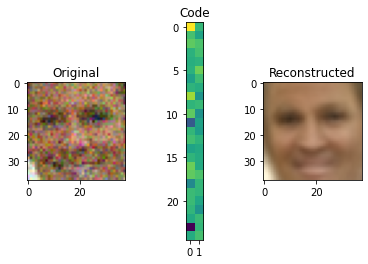

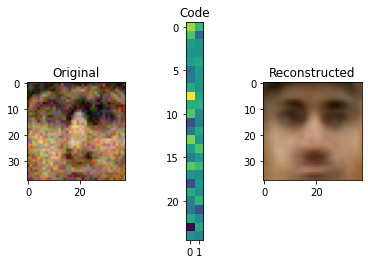

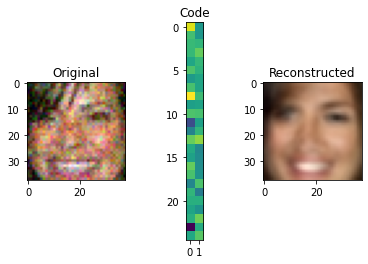

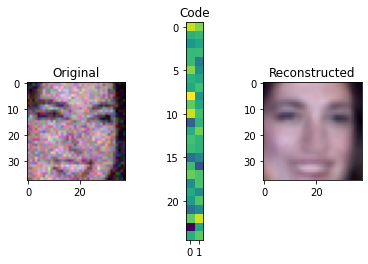

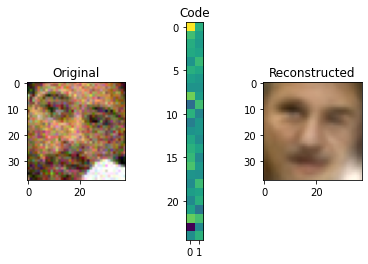

In [252]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

**Bonus**

In [395]:
def apply_rect_noise(X, size: int):
    X = X.clone()
    img_size = X.shape[-2:]
    assert img_size[0] == img_size[1]
    
    n = X.shape[0]
    
    top_left_inds = np.random.randint(0, img_size[0] - size + 1, (n, 2))
    
    for i, (tli_x, tli_y) in enumerate(top_left_inds):
        X[i, :, tli_x:tli_x+size, tli_y:tli_y+size] = 0
        
    return X

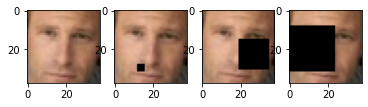

In [405]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_rect_noise(torch.from_numpy(X[:1]), size=4).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_rect_noise(torch.from_numpy(X[:1]), size=16).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_rect_noise(torch.from_numpy(X[:1]), size=24).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [406]:
aenc_rect = DeepAutoencoder()
train(aenc_rect, X_train_tensor, X_test_tensor, 50, noise_function=lambda x: apply_rect_noise(x, 16))

370it [00:07, 49.43it/s]


1, Train loss: 0.024337159249624436, Test loss: 0.03132613761448408


370it [00:07, 50.36it/s]


2, Train loss: 0.01682847687091362, Test loss: 0.028912801704775382


370it [00:07, 49.70it/s]


3, Train loss: 0.01504012610510883, Test loss: 0.02427002672415392


370it [00:07, 50.00it/s]


4, Train loss: 0.013586826178060006, Test loss: 0.0269063474676487


370it [00:07, 50.26it/s]


5, Train loss: 0.012603433211546604, Test loss: 0.021797648303812416


370it [00:07, 50.52it/s]


6, Train loss: 0.011862831989308837, Test loss: 0.02188272385874881


370it [00:07, 51.21it/s]


7, Train loss: 0.011161815318909809, Test loss: 0.021958100831253453


370it [00:07, 51.91it/s]


8, Train loss: 0.010778282348015424, Test loss: 0.023245279397866223


370it [00:07, 51.70it/s]


9, Train loss: 0.010478907658473282, Test loss: 0.0218859449782507


370it [00:07, 49.99it/s]


10, Train loss: 0.010190583204318699, Test loss: 0.024483381818667858


370it [00:07, 51.06it/s]


11, Train loss: 0.0097278975560909, Test loss: 0.01991348065250315


370it [00:07, 51.11it/s]


12, Train loss: 0.0094604435149666, Test loss: 0.01971587577402629


370it [00:07, 49.68it/s]


13, Train loss: 0.00922485933755463, Test loss: 0.01816809505736989


370it [00:07, 50.36it/s]


14, Train loss: 0.009067798313316602, Test loss: 0.01788025111144579


370it [00:07, 50.35it/s]


15, Train loss: 0.008893227757119261, Test loss: 0.02025343072609743


370it [00:07, 50.47it/s]


16, Train loss: 0.008676160977782543, Test loss: 0.016745101868282104


370it [00:07, 50.37it/s]


17, Train loss: 0.0085000001546075, Test loss: 0.02045331430279102


370it [00:07, 50.96it/s]


18, Train loss: 0.00832745720223758, Test loss: 0.016010101155143546


370it [00:07, 50.53it/s]


19, Train loss: 0.00821568388670049, Test loss: 0.017063494686014584


370it [00:07, 49.77it/s]


20, Train loss: 0.0080756010395841, Test loss: 0.01665651073963389


370it [00:07, 50.54it/s]


21, Train loss: 0.007946367842750785, Test loss: 0.014664848425581432


370it [00:07, 51.02it/s]


22, Train loss: 0.00784739807380439, Test loss: 0.01621196065940931


370it [00:07, 49.81it/s]


23, Train loss: 0.007803388525424841, Test loss: 0.013959219004148073


370it [00:07, 50.53it/s]


24, Train loss: 0.007668204809120467, Test loss: 0.012197332395687386


370it [00:07, 51.02it/s]


25, Train loss: 0.007590529491329336, Test loss: 0.017144674786925114


370it [00:07, 51.73it/s]


26, Train loss: 0.007515728719972225, Test loss: 0.01642174790943786


370it [00:07, 50.42it/s]


27, Train loss: 0.007456681490207871, Test loss: 0.015444939713468593


370it [00:07, 51.24it/s]


28, Train loss: 0.007387319824703477, Test loss: 0.012354761223295006


370it [00:07, 50.37it/s]


29, Train loss: 0.007309494775511899, Test loss: 0.014204147186053749


370it [00:07, 51.17it/s]


30, Train loss: 0.00724026306875724, Test loss: 0.014352502796598296


370it [00:07, 50.39it/s]


31, Train loss: 0.007198147736141133, Test loss: 0.013437864523685786


370it [00:07, 50.52it/s]


32, Train loss: 0.007145085586454392, Test loss: 0.013906580753121673


370it [00:07, 49.93it/s]


33, Train loss: 0.007101643847714971, Test loss: 0.015489327419737289


370it [00:07, 50.52it/s]


34, Train loss: 0.0070587094710551305, Test loss: 0.015554022280300823


370it [00:07, 50.92it/s]


35, Train loss: 0.006989169623664026, Test loss: 0.013737676610564584


370it [00:07, 51.03it/s]


36, Train loss: 0.0069478495900630695, Test loss: 0.014430927779583698


370it [00:07, 50.39it/s]


37, Train loss: 0.006893054307307319, Test loss: 0.013478645585214074


370it [00:07, 51.19it/s]


38, Train loss: 0.006887659580771555, Test loss: 0.013960856819923727


370it [00:07, 51.17it/s]


39, Train loss: 0.006821588860546876, Test loss: 0.014796605737349346


370it [00:07, 50.57it/s]


40, Train loss: 0.006785466633504091, Test loss: 0.012260750083791535


370it [00:07, 50.31it/s]


41, Train loss: 0.00675644816450261, Test loss: 0.012541202950215638


370it [00:07, 50.61it/s]


42, Train loss: 0.006741832990381053, Test loss: 0.01373231196015454


370it [00:07, 51.16it/s]


43, Train loss: 0.006689381171495979, Test loss: 0.013560735607611032


370it [00:07, 50.49it/s]


44, Train loss: 0.00668834700146997, Test loss: 0.01227630770635264


370it [00:07, 51.09it/s]


45, Train loss: 0.00661873603212911, Test loss: 0.010928377323982632


370it [00:07, 51.07it/s]


46, Train loss: 0.006605889790473454, Test loss: 0.013233568843551882


370it [00:07, 50.65it/s]


47, Train loss: 0.006580406683141965, Test loss: 0.01253627488689397


370it [00:07, 50.30it/s]


48, Train loss: 0.006541028528293089, Test loss: 0.014450350142933908


370it [00:07, 50.33it/s]


49, Train loss: 0.006528227603176255, Test loss: 0.012155064938390183


370it [00:07, 50.47it/s]

50, Train loss: 0.006453393514431492, Test loss: 0.01492062240401415


We can see inpainting, but sometimes it works not really good (last picture)

Final MSE: 0.0068702381344871374


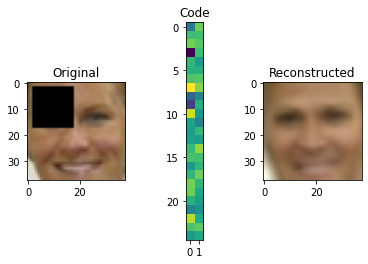

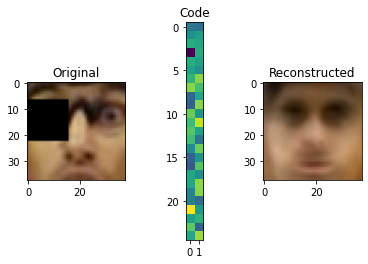

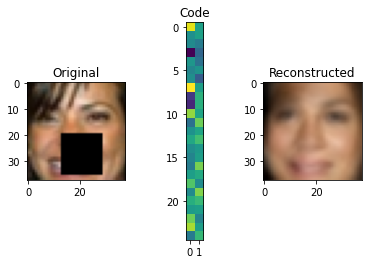

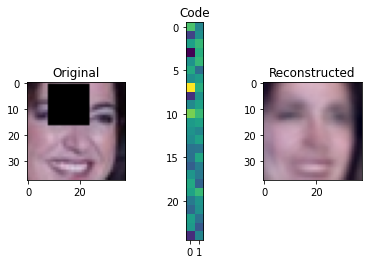

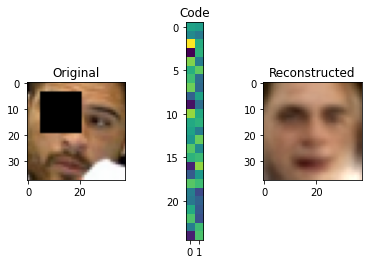

In [418]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_rect_noise(batch, 16).to(device=device)
    scores.append(aenc_rect.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_rect.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_rect_noise(X_test_tensor[i].unsqueeze(0), 16)
    visualize(img[0], aenc_rect)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [277]:
#encodes batch of images into a codes

# <encode all images in X_train_tensor>
codes = aenc.enc(X_train_tensor.to(device))

In [278]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [302]:
# from sklearn.neighbors import LSHForest
# lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

I used another alogirthm for embedding search because LSHForest is depricated and it hard to make it work

In [303]:
from sklearn.neighbors import KDTree
lshf = KDTree(codes.detach().cpu().numpy())

In [310]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [311]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
#     (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    (distances,),(idx,) = lshf.query(code, k=n_neighbors)
    
    return distances,images[idx]

In [312]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

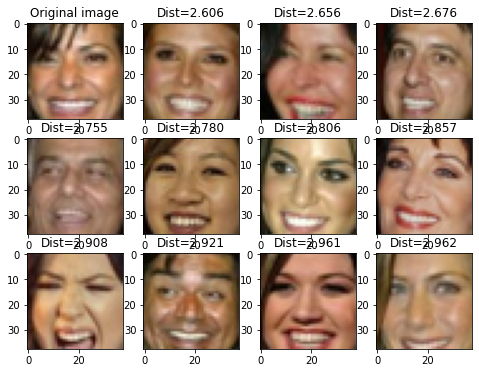

In [313]:
#smiles
show_similar(X_test_tensor[2])

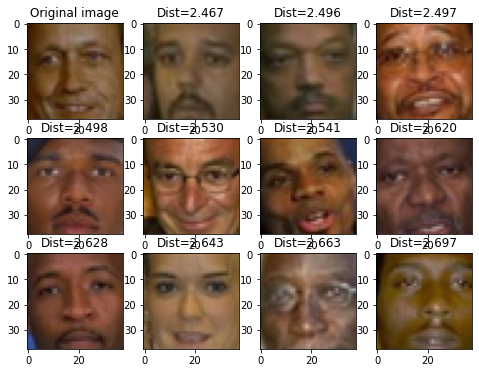

In [314]:
#ethnicity
show_similar(X_test_tensor[500])

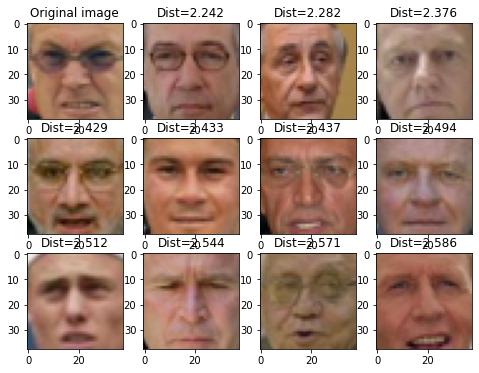

In [315]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


In [318]:
output_image.cpu().detach().numpy().shape

(3, 38, 38)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


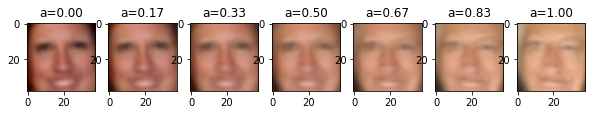

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


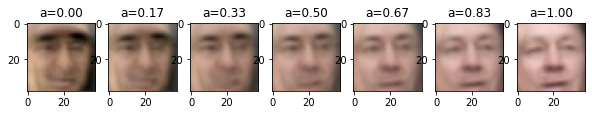

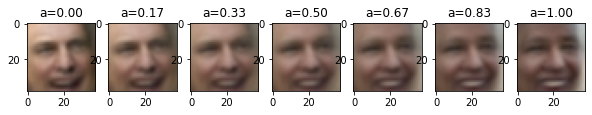

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


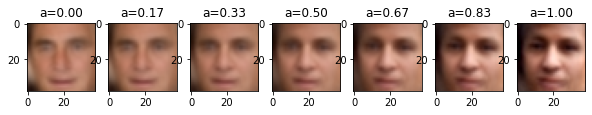

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


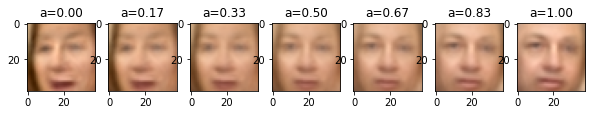

In [321]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        output_image = output_image.cpu().detach()
        output_image = torch.permute(output_image, [1, 2, 0]).numpy()
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.